In [1]:
import numpy as np
import sim_constants as const
import sim_functions as sim
import init_functions as init
from numba import njit, prange
import scipy.integrate as INT
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch

# UNKNOWN IMPORT - meant for files?
# from tkinter.filedialog import askopenfilename
# import tkinter

In [2]:
"""
Code to draw vector arrows in the 3D plot
"""
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

setattr(Axes3D, 'arrow3D', _arrow3D)

In [3]:
# TODO: messy, clean up

# Load a file. If True you will get prompted to open one. if False, it will use random initial conditions
load_file = False

# Set file name for saving after
path = 'change_name.npy'

# Number of ions to model
N = 6

"""
Integration Parameters
"""
# Integration step
# t_int=5e-9

# set integration time to 1/20 of period
t_int = 1/(const.Omega/2/np.pi)/20

# If not loading from a file: -------
# total time
Tfinal = 0.005

# Timestep at which to record data (cant be lower than t_int and should be a multiple of it)
t_step = 2 * t_int

# Time variable to start at (so you don't record the whole cooling part if you don;t want to)
t_start = 0

#Times at which to integrate
trange = [0, Tfinal]

# Times to record data
t2 = np.arange(t_start, Tfinal, t_int)
# ------------

"""
Initial Conditions Parameters
"""
# Initial conditions of barium ions, temperature, boltzman mean and std
Tb = 150

# Size of grid where initial positions may start
start_area = 200e-6

# Random initial conditions
IC = init.initialize_ions(N, start_area, Tb)

start = time.time()
print("simulation has started")

# Using the leap frog algorithm (simulate trajectories with no micromotion)
time_elapsed, trajectories = sim.leap_frog(N, Tfinal, t_int, np.array(IC))
print("time elapsed:", time_elapsed)
print("trajectories:", trajectories)

print("simulation has finished and took", time.time() - start, "s")

simulation has started
time elapsed: [0.00000000e+00 4.01284109e-09 8.02568218e-09 ... 4.99998395e-03
 4.99998796e-03 4.99999197e-03]
trajectories: [[-9.95877593e-05 -9.95043891e-05 -9.94136639e-05 ...  6.22140840e-06
   6.21842399e-06  6.21563265e-06]
 [-8.38611882e-05 -8.39358056e-05 -8.40037277e-05 ...  4.17163764e-06
   4.17255051e-06  4.17349809e-06]
 [ 2.70877544e-06  2.66737001e-06  2.62494991e-06 ...  7.50585448e-08
   7.37672794e-08  7.21887088e-08]
 ...
 [ 1.46386122e+02  1.43280482e+02  1.41596016e+02 ...  2.83173657e-01
   2.61080890e-01  2.56224742e-01]
 [-5.61913927e+01 -5.43896610e+01 -5.40889783e+01 ... -4.12035960e-01
  -4.29492223e-01 -4.63134833e-01]
 [-3.39105132e+01 -3.06670339e+01 -2.82756144e+01 ... -1.27431317e-01
  -1.12687428e-01 -1.09498386e-01]]
simulation has finished and took 28.846987009048462 s


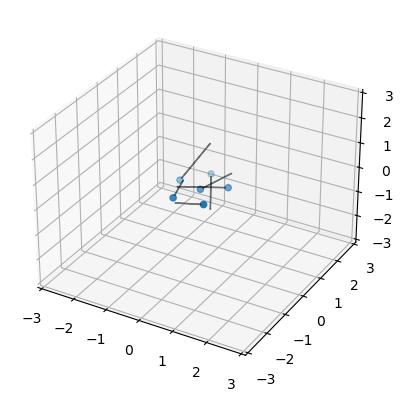

In [4]:
def get_final_positions_and_velocities(trajectories, N):
    """
    Params
    ------
    trajectories : np.array
        a (6, N, iterations) array for the trajectories of the ions at every iteration
    N : int
        the number of ions in the trap
    
    Return
    ------
    fpos : tuple -> (np.array, np.array, np.array)
        the final positions of the ions, (xcoords, ycoords, zcoords)
    fvel : tuple -> (np.array, np.array, np.array)
        the final velocities of the ions, (xvels, yvels, zvels)
    """
    xcord = np.zeros(N, dtype=np.float64)
    ycord = np.zeros(N, dtype=np.float64)
    zcord = np.zeros(N, dtype=np.float64)
    
    xvel = np.zeros(N, dtype=np.float64)
    yvel = np.zeros(N, dtype=np.float64)
    zvel = np.zeros(N, dtype=np.float64)
    
    for i in range(0, N):
        # Get final position coordinates
        xcord[i] = trajectories[3*i, -1]
        ycord[i] = trajectories[3*i + 1, -1]
        zcord[i] = trajectories[3*i + 2, -1]
    
        # Get final velocity coordinates
        xvel[i] = trajectories[3*N+3*i, -1]
        yvel[i] = trajectories[3*N+3*i + 1, -1]
        zvel[i] = trajectories[3*N+3*i + 2, -1]
        
    fpos = (xcord, ycord, zcord)
    fvel = (xvel, yvel, zvel)
    return fpos, fvel

def plot_ions(fpos, fvel, pscale=30e-6):
    """
    Params
    ------
    fpos : tuple -> (np.array, np.array, np.array)
        the final positions of the ions, (xcoords, ycoords, zcoords)
    fvel : tuple -> (np.array, np.array, np.array)
        the final velocities of the ions, (xvels, yvels, zvels)
    pscale : float, optional
        the scale of the 3D plot for all axes
    """
    xcord, ycord, zcord = fpos
    xvel, yvel, zvel = fvel
    ax = plt.axes(projection='3d')
    ax.set_zlabel(r'Z', fontsize=20)
    ax.set_xlim3d(-pscale, pscale)
    ax.set_ylim3d(-pscale, pscale)
    ax.set_zlim3d(-pscale, pscale)
    ax.scatter3D(xcord, ycord, zcord)

    for i in range(0, N):
        vel_i = np.zeros(3)
        vel_i[0], vel_i[1], vel_i[2] = xvel[i], yvel[i], zvel[i]
        vel_i *= pscale
        ax.arrow3D(xcord[i], ycord[i], zcord[i], vel_i[0], vel_i[1], vel_i[2], alpha=0.5)

    plt.show()
    
fpos, fvel = get_final_positions_and_velocities(trajectories, N)
plot_ions(fpos, fvel)